# Netflix Stock Market Analysis and Prediction
![](images/netflix.jpg)
  

## 1. Introduction
Netflix became one of the successful video streaming websites that has been growing rapidly. The company itself has been investing internationally to attract viewers from all over the world. People are willing to pay monthly subscription fees just to watch one of the most popular TV shows at the moment. So how is it doing on the Stock Market? If you already have Netflix Stocks, is it better to keep or sell? Will there be any increase or decrease of the current value of stocks? DailyMarket Co. is here to help! Just download our mobile app and we will provide the most recent analysis daily. 

## 2. Business Problem
DailyMarket Co. is a start up mobile app company that provides stock market information such as forecasting the stock price. Company has hired a team to provide the most accurate forecasting on stock market closing prices. As a team member of the company, I will be doing Netflix Analysis and Predictions from 12 months to 36 months. It is crucial to provide the most accurate forecasting since the company just launched the mobile app. 


In [68]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

import yfinance as yf
from yahoofinancials import YahooFinancials

from pylab import rcParams
import statsmodels.api as sm
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import math
from numpy import mean
from math import sqrt
from sklearn.model_selection import cross_val_score
from tscv import GapKFold
from sklearn import svm

sns.set_style("whitegrid")

## 3. Data

The Netflix stock market data was obtained by using the Yahoo Finance API <code>yfinance</code>. According to the [Bloomberg](https://www.bloomberg.com/news/articles/2022-01-21/netflix-peloton-bring-the-pandemic-stock-era-to-shuddering-halt), Netflix went public in May 2002. Therefore, in order to see the whole history of Netflix stock market, the initially dataset was created from <code>2002-06-01 to 2022-01-31</code> to observe history of the stock prices.
</br>
</br>
Also, data can be viewed and downloaded from [Netflix Yahoo Finance](https://finance.yahoo.com/quote/NFLX/).

In [2]:
#loading dataset by using yfinance
NFLX = yf.download('NFLX',
                start='2002-06-01',
                end='2022-01-31',
                progress=False,
                )
NFLX.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-06-03,1.080000,1.149286,1.076429,1.128571,1.128571,3151400
2002-06-04,1.135714,1.140000,1.110714,1.117857,1.117857,3105200
2002-06-05,1.110714,1.159286,1.107143,1.147143,1.147143,1531600
2002-06-06,1.150000,1.232143,1.148571,1.182143,1.182143,2305800
2002-06-07,1.177857,1.177857,1.103571,1.118571,1.118571,1369200


In [3]:
#Assigning 'Date' as an index
NFLX['Date'] = NFLX.index

In [4]:
#looking at info
NFLX.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4951 entries, 2002-06-03 to 2022-01-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       4951 non-null   float64       
 1   High       4951 non-null   float64       
 2   Low        4951 non-null   float64       
 3   Close      4951 non-null   float64       
 4   Adj Close  4951 non-null   float64       
 5   Volume     4951 non-null   int64         
 6   Date       4951 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 309.4 KB


In [5]:
#checking any missing values
NFLX.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
dtype: int64

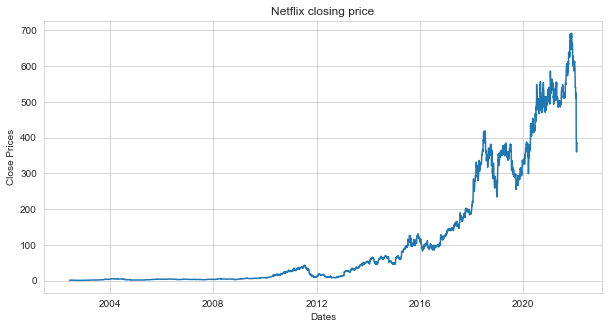

In [6]:
#Visualize the daily closing price
plt.figure(figsize=(10,5))
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(NFLX['Close'])
plt.title('Netflix closing price')
plt.show()

▶ After launching in 2002, the closing price was very low and almost steady. The price started to picking up from 2016. Then the closing price was increased from 2020 and drastically decreased towards the end of the time period. 

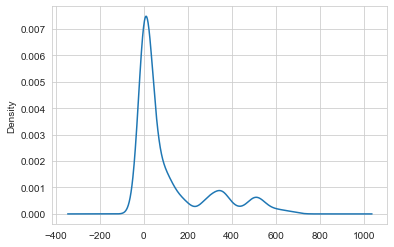

In [7]:
#Distribution of the dataset
cp = NFLX['Close']
cp.plot(kind='kde')

▶Graph is prepared by using <code>kernel density estimation(KDE)</code>. KDE represents the data using a continuous probability density curve in dimensions. The graph seems multimodal distribution since the large peak is followed by small peaks.

▶After visualizing the data, it seems reasonable to use recent 5 years. Although the closing price was generally positive(increased), it took awhile for Netflix to pick up. Therefore, eliminating the beginning of the dataset will help to get closer look of the data.

In [8]:
#importing saved dataset that are recent 5 yrs
import os
df = pd.read_csv(os.path.join("data", "NFLX.csv"))
df1 = pd.read_csv(os.path.join("data", "NFLX.csv"))
df['Date'] = pd.to_datetime(df['Date'])
df_sort = df.sort_values(by='Date', ascending=True)
df_sort.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-08,143.570007,145.070007,142.559998,144.740005,144.740005,6887100
1,2017-02-09,144.979996,145.089996,143.580002,144.139999,144.139999,4555100
2,2017-02-10,144.679993,145.300003,143.970001,144.820007,144.820007,6171900
3,2017-02-13,145.190002,145.949997,143.050003,143.199997,143.199997,4790400
4,2017-02-14,143.199997,144.110001,140.050003,140.820007,140.820007,8367800


## 4.Stationarity

Most of the time series dataset contains both systematic (level, trend, and seasonality) and non-systematic components(noise or random variance). Each components will cause inaccurate predictions. In order to create the best forecasting model, establishing **stationary data** by removing all the compoments will be essential. 

**ADF(Augmented Dickey-Fuller) Test** will be used to determine the stationarity by checking on the **null hypothesis** (series has a unit root; a=1) and **alternative hypothesis** (series has no unit root). The series is non-stationary if the null hypothesis is not rejected. 
</br>
[Reference Link](https://machinelearningmastery.com/time-series-data-stationary-python)

In [9]:
#setting up index
df_c = df1[['Date', 'Close']]
df_idx = df_c.set_index('Date')
df_idx.index = pd.to_datetime(df_idx.index)
df_idx.head()

,Close
Date,
2017-02-08,144.740005
2017-02-09,144.139999
2017-02-10,144.820007
2017-02-13,143.199997
2017-02-14,140.820007


In [10]:
#creating stationarity check 
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=18, center=False).mean()
    roll_std = TS.rolling(window=18, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS.dropna()) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

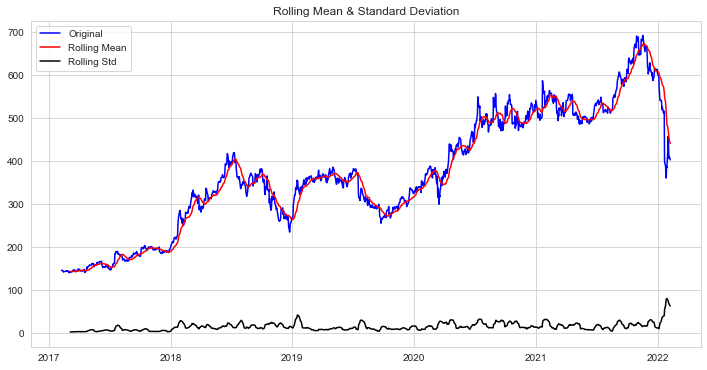

Results of Dickey-Fuller Test: 

Test Statistic                   -1.797600
p-value                           0.381654
#Lags Used                       23.000000
Number of Observations Used    1235.000000
Critical Value (1%)              -3.435656
Critical Value (5%)              -2.863883
Critical Value (10%)             -2.568018
dtype: float64


In [11]:
#checking statoinarity by using function
stationarity_check(df_idx)

▶ By using <code>stationarity_check()</code> function, we are able to check the stationarity by both visually and mathematically. 
</br>
First, we can't rule out the Null hypothesis since **p-value** is **0.38** which is greater than 0.05. Also, test statistics(-1.80) is exceeded critical values (-3.43, -2.86, and -2.57). Therefore this dataset is currently non-stationary.

## 5. Decomposition

Decomposing time series into multiple

<Figure size 432x288 with 0 Axes>

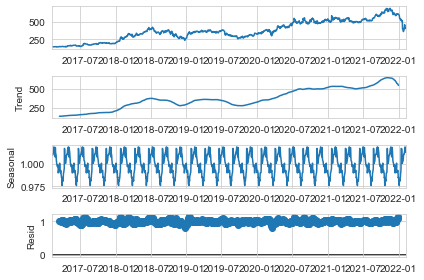

In [12]:
decomposition = seasonal_decompose(df_idx, model='multiplicative', freq = 50)
fig = plt.figure()  
fig = decomposition.plot()  

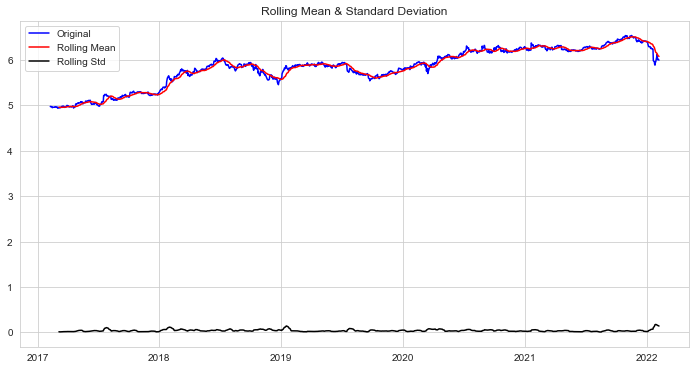

Results of Dickey-Fuller Test: 

Test Statistic                   -2.106723
p-value                           0.241820
#Lags Used                        6.000000
Number of Observations Used    1252.000000
Critical Value (1%)              -3.435584
Critical Value (5%)              -2.863851
Critical Value (10%)             -2.568001
dtype: float64


In [13]:
#removing Trend
log_df = np.log(df_idx)
stationarity_check(log_df)

▶After removing trend, **p-value** has been decreased to **0.24**. However, it is still violating the null hypothesis and will continue removing components.

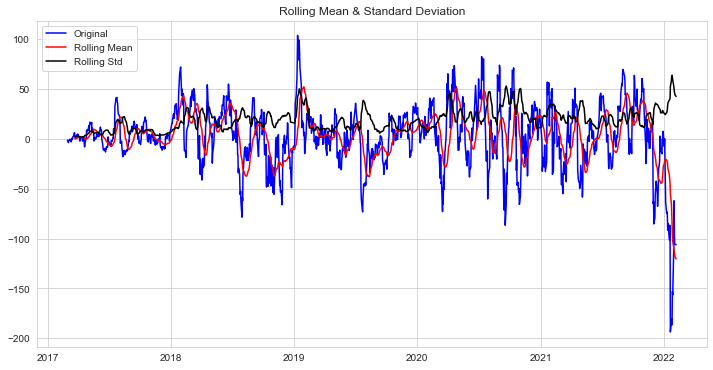

Results of Dickey-Fuller Test: 

Test Statistic                   -5.278178
p-value                           0.000006
#Lags Used                       20.000000
Number of Observations Used    1226.000000
Critical Value (1%)              -3.435695
Critical Value (5%)              -2.863900
Critical Value (10%)             -2.568027
dtype: float64


In [14]:
#remove seasonality
diff = df_idx.diff(periods=12)
# drop any null values
diff.dropna(inplace=True)
stationarity_check(diff)

▶After taking out the seasonality by differencing, p-value has been decreased to 0.000006. Since current **p-value < 0.05**, null hypothesis has been rejected. Also test statistic is now smaller than critical values.

## 6. Split Tests

In [15]:
# calculate a train-test split of a time series dataset from 
from matplotlib import pyplot
def time_series_split_visual(tsval):
    X = tsval.values
    train_size = int(len(X)*0.66) #reading 66% as train and rest 34% as test
    train, test = X[0:train_size], X[train_size:len(X)]
    print('Observations: %d' % (len(X)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.rcParams["figure.figsize"] = (20,10)
    pyplot.plot(train) 
    pyplot.plot([None for i in train] + [x for x in test])
    pyplot.show()

Observations: 1247
Training Observations: 823
Testing Observations: 424


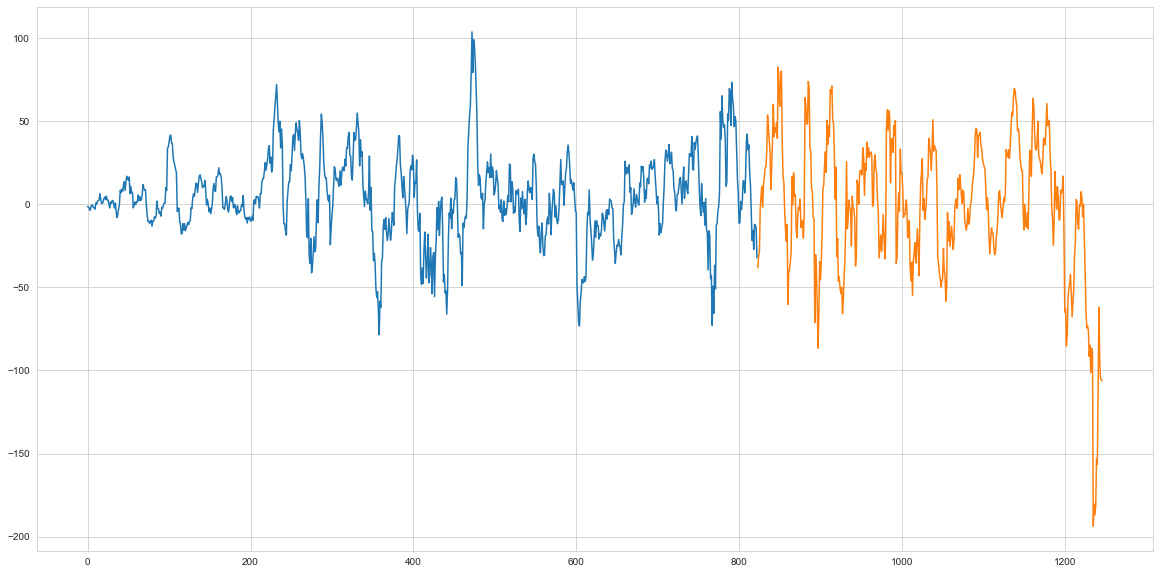

In [16]:
time_series_split_visual(diff)

▶Visually, Splitting onces seems good but let's split three times to see if there are any differences.

Observations: 625
Training Observations: 314
Testing Observations: 311
Observations: 936
Training Observations: 625
Testing Observations: 311
Observations: 1247
Training Observations: 936
Testing Observations: 311


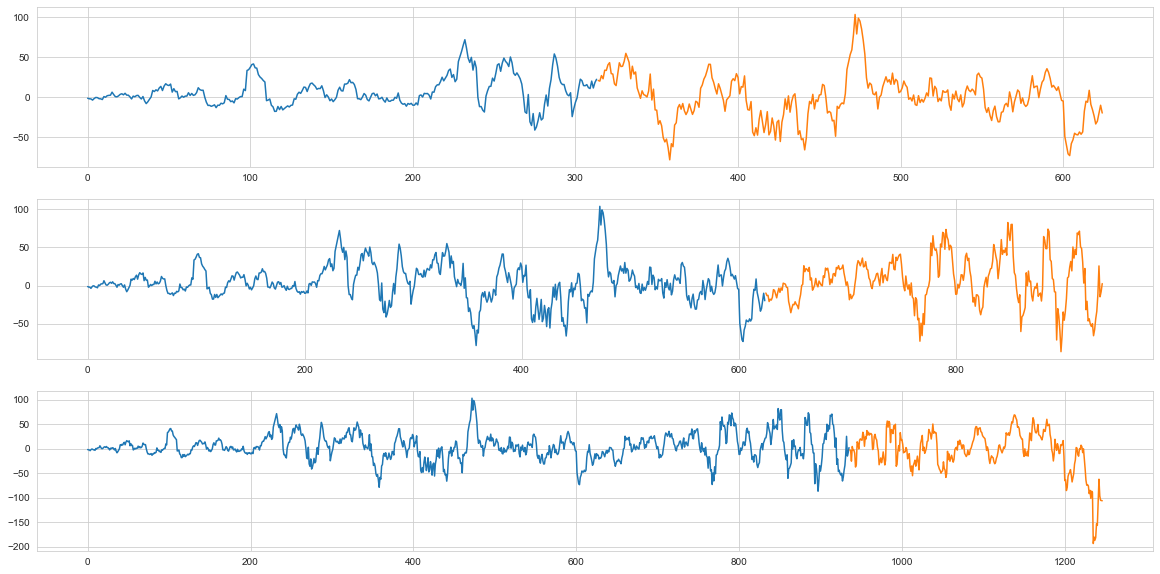

In [17]:
#based on the time series split, creating 3 splits.
X = diff.values

splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)

#creating index for train and test
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    
    #printing out the splitted observations
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    
    #plotting all 3 splitted obs
    plt.rcParams["figure.figsize"] = (20,10)
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    
    index += 1
pyplot.show()

In [18]:
#Measuring forecast error
X = diff.values #Value of the data
window = 1
history = [X[i] for i in range(window)]#original
test = [X[i] for i in range(window, len(X))]#observed test

#creating predictions
predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    
print('predicted=%f, expected=%f' % (yhat, obs))

#calculating the error
expected = test
mae = mean_absolute_error(expected, predictions)
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print(mae,mse,rmse)

predicted=-105.689972, expected=-106.149994
9.176148121187804 177.56451332600165 13.325333516501628


In [74]:
#cross validating on traing test
iris=load_iris()
X=iris.data
Y=iris.target
print("Size of Dataset {}".format(len(X)))

logreg=LogisticRegression()
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
logreg.fit(x_train,y_train)
predict=logreg.predict(x_test)

print("Accuracy score on training set is {}".format(accuracy_score(logreg.predict(x_train),y_train)))
print("Accuracy score on test set is {}".format(accuracy_score(predict,y_test)))

Size of Dataset 150
Accuracy score on training set is 0.9619047619047619
Accuracy score on test set is 1.0


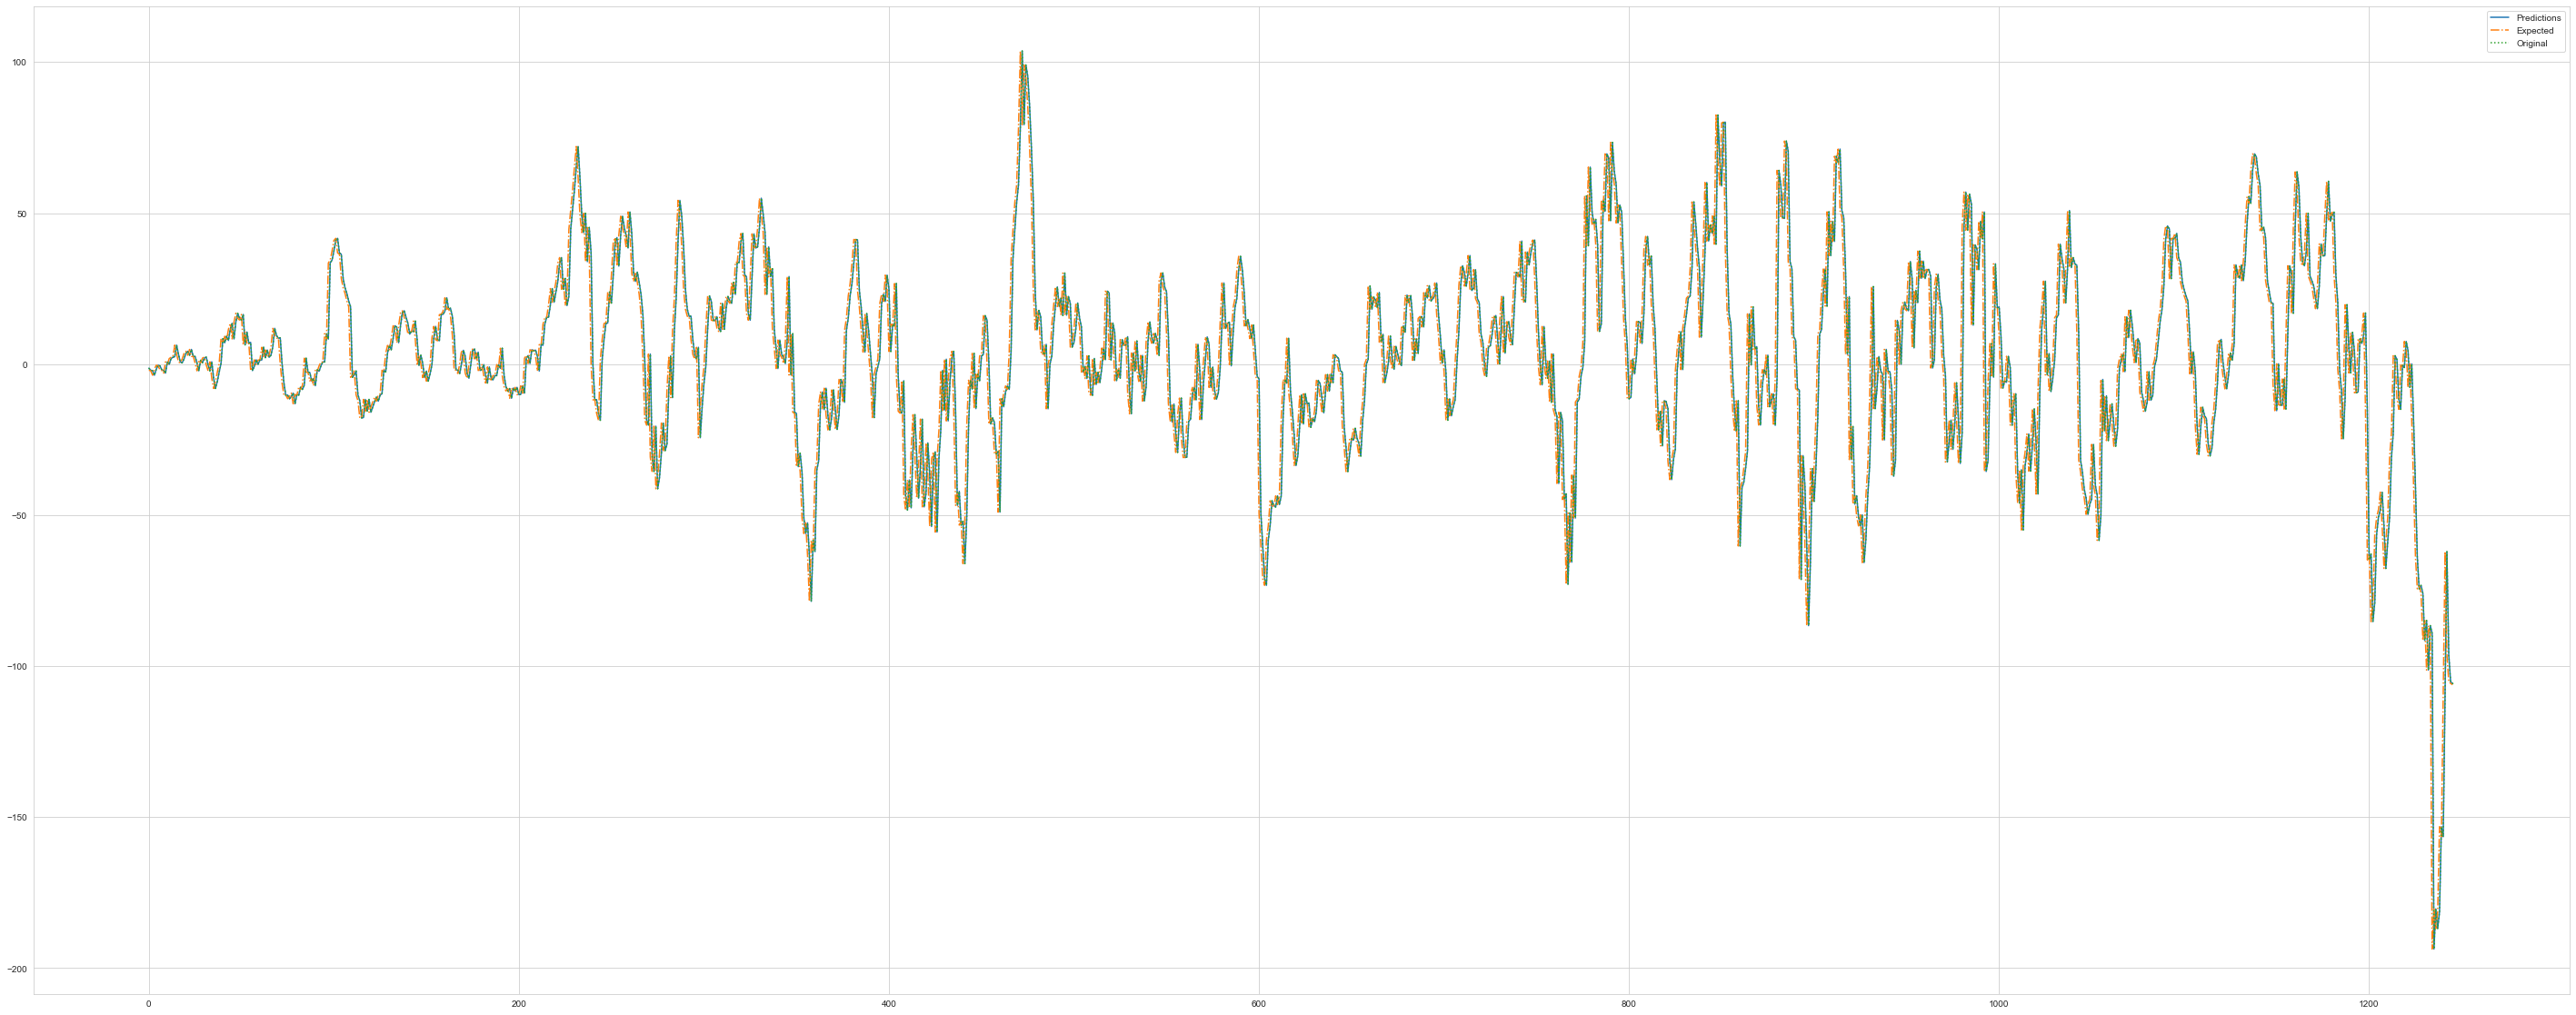

In [19]:
#Visualizing prediction, original, and test
plt.figure(figsize=(50,20))
plt.plot(predictions, label = "Predictions")
plt.plot(test, label = "Expected", linestyle="-.")
plt.plot(history, label = "Original", linestyle=":")

plt.legend()
plt.show()

It's hard to see (making it bigger only made harder to see) But visually, all predicted, expected and original seems like lined up.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12179.600, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9952.017, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11136.537, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9953.005, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9953.095, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9954.467, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9953.895, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.794 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1247
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4974.008
Date:                Thu, 10 Feb 2022   AIC                           9952.017
Time:                        10:01:09   BIC                           9962.274
Sample:              

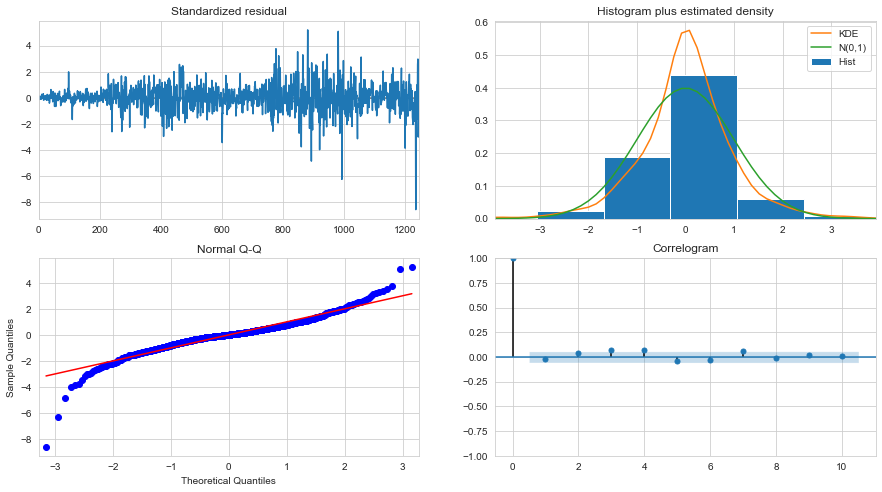

In [20]:
model_autoARIMA = auto_arima(diff, start_p=0, start_q=0,
                      test='adf',       # use adftest
                      max_p=3, max_q=3,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [21]:
#creating SARIMAX and fit
mod = sm.tsa.statespace.SARIMAX(diff,
                                order=(1, 0, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\9123\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\9123\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9485      0.008    125.043      0.000       0.934       0.963
ar.S.L12      -0.4603      0.019    -23.817      0.000      -0.498      -0.422
ma.S.L12      -1.0000     64.546     -0.015      0.988    -127.508     125.508
sigma2       140.7629   9083.401      0.015      0.988   -1.77e+04    1.79e+04


In [22]:
#fit the model
model = ARIMA(train, order=(1,0,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  936
Model:                     ARMA(1, 1)   Log Likelihood               -3636.921
Method:                       css-mle   S.D. of innovations             11.773
Date:                Thu, 10 Feb 2022   AIC                           7281.841
Time:                        10:01:13   BIC                           7301.208
Sample:                             0   HQIC                          7289.225
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3770      3.925      1.115      0.265      -3.315      12.069
ar.L1.y        0.9081      0.015     61.624      0.000       0.879       0.937
ma.L1.y       -0.0530      0.032     -1.669      0.0

Text(0.5, 1.0, 'Forecast')

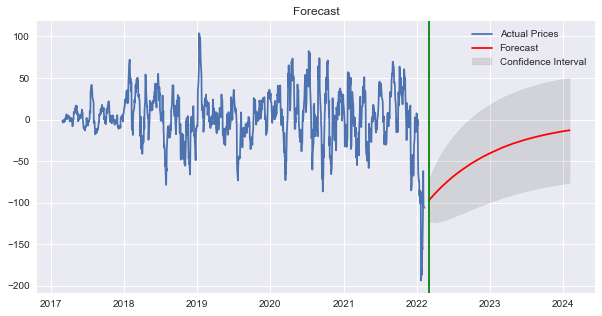

In [23]:
#this model is specifically 
model_1 = model_autoARIMA
#including last date from known dates to get pred
dti = pd.date_range(df_idx.index[-1], periods=24, freq="MS") 

# creating Forecast
n_periods = 24
fc, confint = model_1.predict(n_periods=24, return_conf_int=True)
index_of_fc = dti

# make series for plotting 
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.style.use('seaborn')
plt.figure(figsize=(10,5))
plt.plot(diff, label="Actual Prices")
plt.plot(fc_series, color='red', label="Forecast")
#filling in between series
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.10, label="Confidence Interval")
# show where forecast starts
plt.axvline(dti[0], color='green') 
plt.legend()
plt.title("Forecast")

Although I have established stationary data, it seems like it cannot make a good forecast overall. Let's try to analyze 3 months period.

## 7. 3 Months Analysis

In [24]:
three_months = pd.read_csv(os.path.join("data", "NFLX (2).csv"))

In [25]:
three_months.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-10,653.01001,660.330017,642.109985,646.909973,646.909973,2405800
1,2021-11-11,650.23999,665.820007,649.710022,657.580017,657.580017,2868300
2,2021-11-12,660.01001,683.340027,653.820007,682.609985,682.609985,4192700
3,2021-11-15,681.23999,685.260010,671.489990,679.330017,679.330017,2872200
4,2021-11-16,678.27002,688.359985,676.900024,687.400024,687.400024,2077400


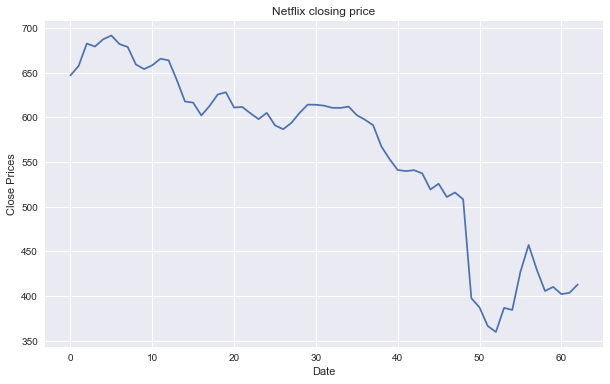

In [26]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(three_months['Close'])
plt.title('Netflix closing price')
plt.show()

In [27]:
tmo = three_months[['Date', 'Close']]
tmo_idx = tmo.set_index('Date')
tmo_idx.index = pd.to_datetime(tmo_idx.index)
tmo_idx.head()

,Close
Date,
2021-11-10,646.909973
2021-11-11,657.580017
2021-11-12,682.609985
2021-11-15,679.330017
2021-11-16,687.400024


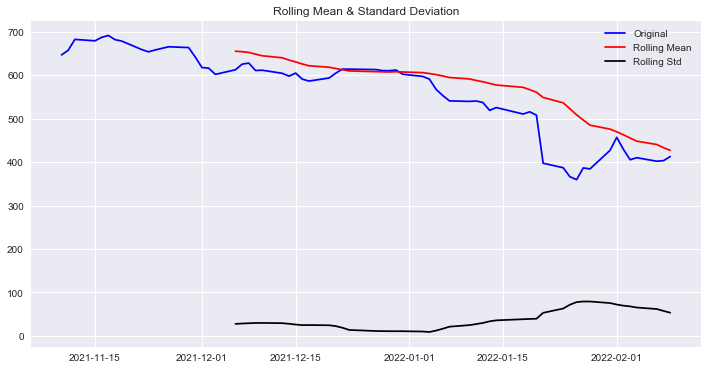

Results of Dickey-Fuller Test: 

Test Statistic                 -0.248521
p-value                         0.932485
#Lags Used                      0.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [28]:
stationarity_check(tmo_idx)

0.9 is such a high p-value. Need to remove the components to make the dataset stationary.

<Figure size 576x396 with 0 Axes>

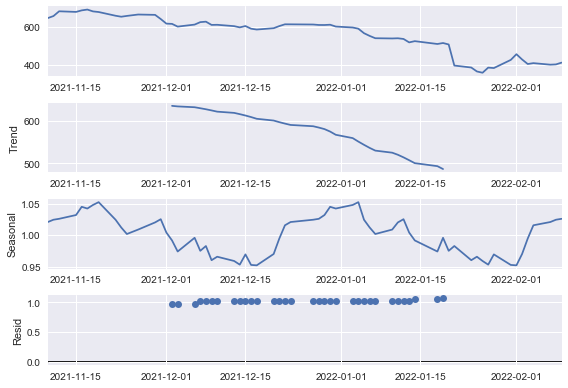

In [29]:
decomposition = seasonal_decompose(tmo_idx, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = decomposition.plot()  

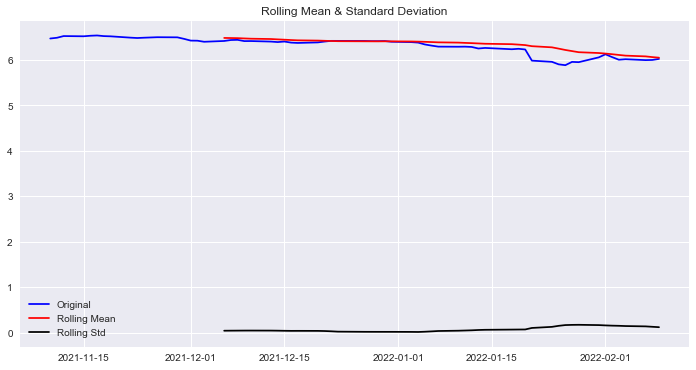

Results of Dickey-Fuller Test: 

Test Statistic                 -0.289430
p-value                         0.926988
#Lags Used                      4.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


In [30]:
#removing Trend
log_tmo = np.log(tmo_idx)
stationarity_check(log_tmo)

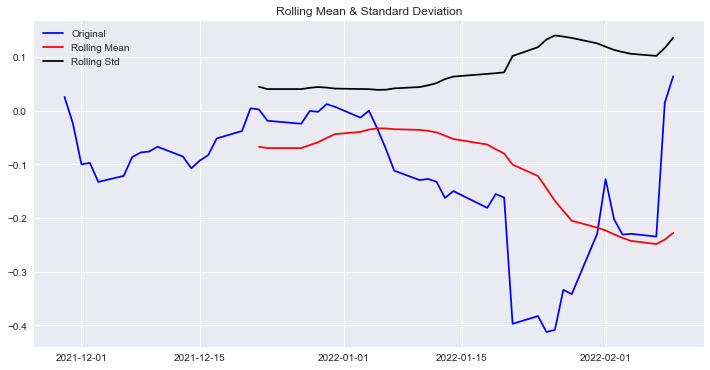

Results of Dickey-Fuller Test: 

Test Statistic                 -3.862859
p-value                         0.002326
#Lags Used                     11.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


In [31]:
#remove seasonality
diff_3mo = log_tmo.diff(periods=12)
# drop any null values
diff_3mo.dropna(inplace=True)
stationarity_check(diff_3mo)

Since P-value is less than 0.05, I can safely say this reject null hypothesis. 

Observations: 51
Training Observations: 33
Testing Observations: 18


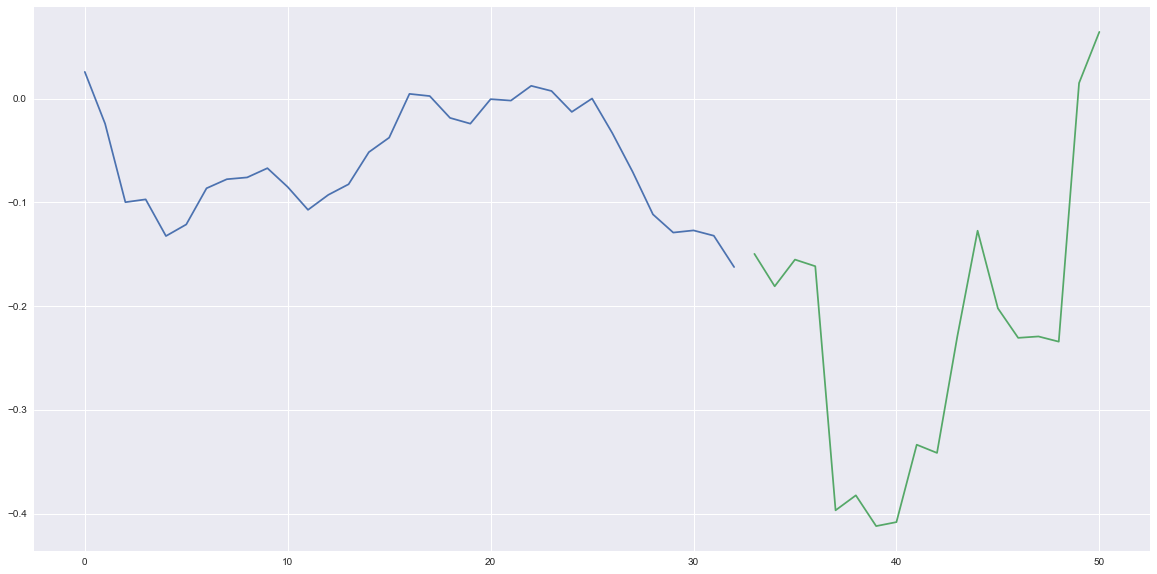

In [32]:
time_series_split_visual(diff_3mo)

Observations: 27
Training Observations: 15
Testing Observations: 12
Observations: 39
Training Observations: 27
Testing Observations: 12
Observations: 51
Training Observations: 39
Testing Observations: 12


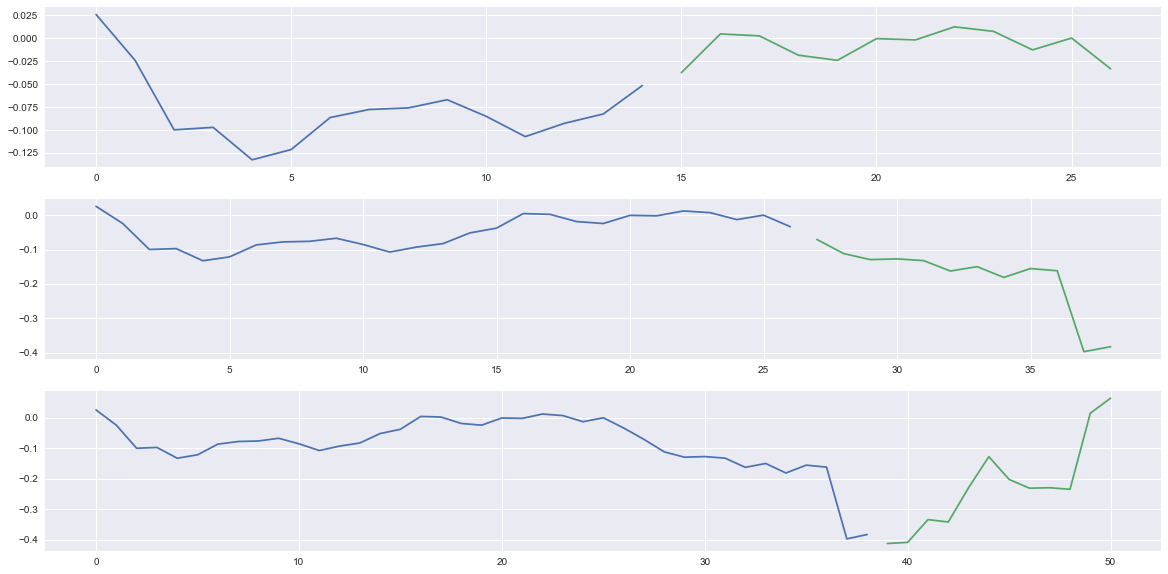

In [33]:
#based on the time series split, creating 3 splits.
X = diff_3mo.values

splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)

#creating index for train and test
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    
    #printing out the splitted observations
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    
    #plotting all 3 splitted obs
    plt.rcParams["figure.figsize"] = (10,5)
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    
    index += 1
pyplot.show()

In [34]:
#Measuring forecase error
X_3mo = diff_3mo.values #Value of the data
window = 1
history = [X_3mo[i] for i in range(window)]#original
test = [X_3mo[i] for i in range(window, len(X_3mo))]#observed test

#creating predictions
predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    
print('predicted=%f, expected=%f' % (yhat, obs))

#calculating the error
expected = test
mae = mean_absolute_error(expected, predictions)
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print(mae,mse,rmse)

predicted=0.015056, expected=0.064369
0.03436090301714183 0.003605899243354953 0.06004914023826614


▶ mean absolute error and mean squared errors are much lower here than doing 5 years.

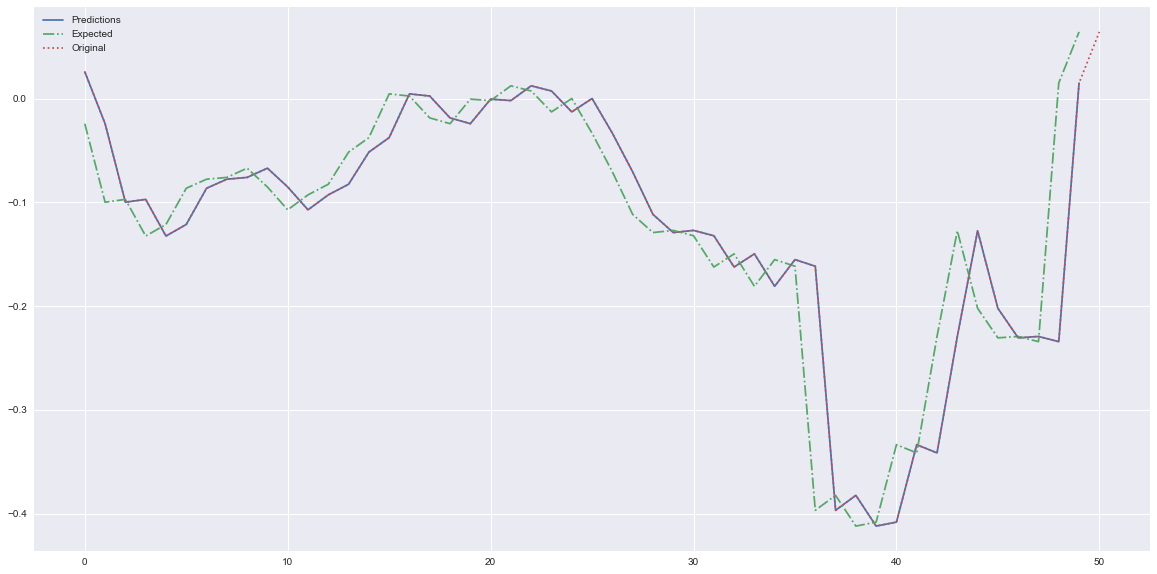

In [35]:
#Visualizing prediction, original, and test
plt.figure(figsize=(20,10))
plt.plot(predictions, label = "Predictions")
plt.plot(test, label = "Expected", linestyle="-.")
plt.plot(history, label = "Original", linestyle=":")

plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-95.333, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-109.028, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-115.979, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-97.304, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-113.997, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-113.942, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-117.213, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-115.447, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-115.486, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-110.996, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-115.207, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.804 seconds
                               SARIMAX Results                                
Dep. Variable:  

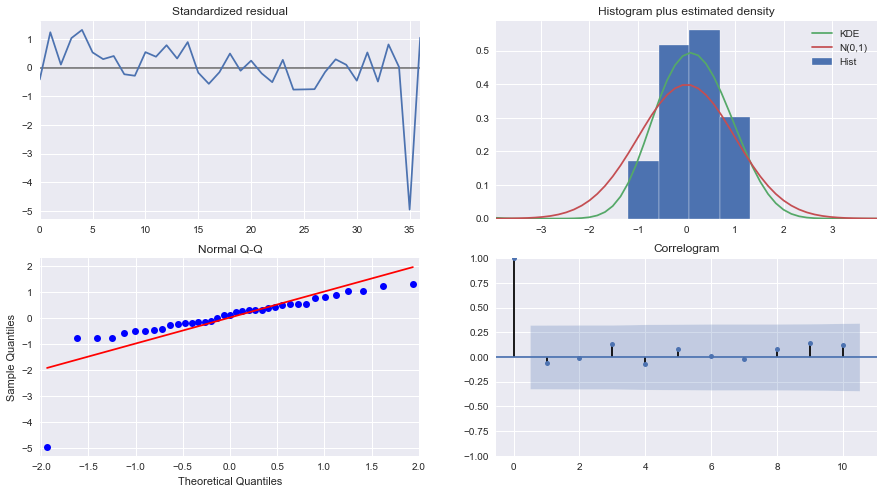

In [36]:
model_autoARIMA_1 = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest
                      max_p=3, max_q=3,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_1.summary())
model_autoARIMA_1.plot_diagnostics(figsize=(15,8))
plt.show()

In [37]:
model = ARIMA(train, order=(0, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   37
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  60.993
Method:                       css-mle   S.D. of innovations              0.044
Date:                Thu, 10 Feb 2022   AIC                           -115.985
Time:                        10:01:19   BIC                           -111.152
Sample:                             2   HQIC                          -114.281
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.175      0.240      -0.002       0.001
ma.L1.D2.y    -0.9999      0.133     -7.491      0.000      -1.262      -0.738
                                    Roots           

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9759.570, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11810.718, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9756.725, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10832.255, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9757.851, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9757.955, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9758.159, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9757.994, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.049 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1235
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4876.363
Date:                Thu, 10 Feb 2022   AIC                           9756.725
Time:                        10:01:20   BIC                           9766.963
Sample:                             0   HQIC                          9760.576
                               - 1235                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9033      0.011     82.465      0.000       0.882       0.925
sigma2       157.2292      3.593     43.759      0.000     150.187     164.271
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):               998.98
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               3.64   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

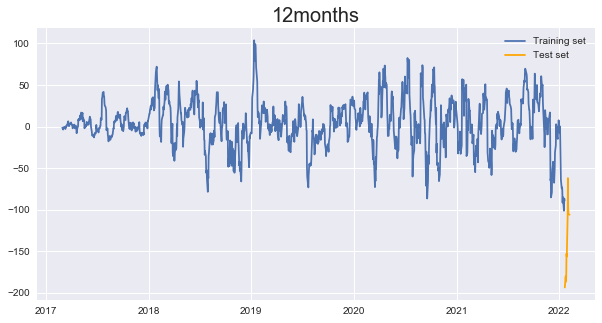

In [38]:
#creating logged test size for 12 months
test_size = 12

#assigning train and test
train_diff = diff[:-test_size]
test_diff = diff[-test_size:]

#creating visualization
plt.title('12months', size=20)
plt.plot(train_diff, label='Training set')
plt.plot(test_diff, label='Test set', color='orange')
plt.legend();

#creating model with logged 12 mo
arima_model_1 = auto_arima(train_diff, seasonal=False, 
                          error_action='ignore',trace = True,
                          supress_warnings=True, n_fits = 50 )
arima_model_1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9655.077, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11629.249, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9651.913, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10673.379, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9652.996, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9653.098, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9653.503, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9652.164, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.052 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1223
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4823.956
Date:                Thu, 10 Feb 2022   AIC                           9651.913
Time:                        10:01:22   BIC                           9662.131
Sample:                             0   HQIC                          9655.758
                               - 1223                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8949      0.011     79.849      0.000       0.873       0.917
sigma2       155.9525      3.554     43.884      0.000     148.987     162.918
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):              1042.25
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               3.77   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

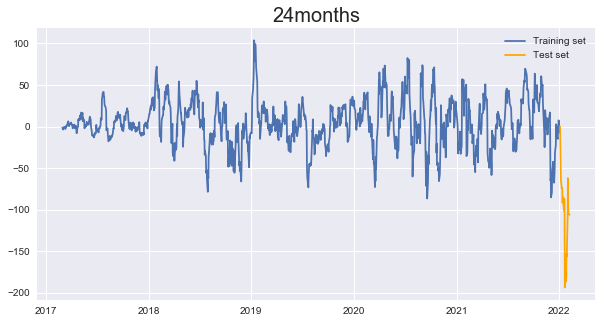

In [39]:
#creating logged test size for 24 months
test_size = 24

#assigning train and test
train_diff = diff[:-test_size]
test_diff = diff[-test_size:]

#creating visualization
plt.title('24months', size=20)
plt.plot(train_diff, label='Training set')
plt.plot(test_diff, label='Test set', color='orange')
plt.legend();

#creating model with logged 24 mo
arima_model_24 = auto_arima(train_diff, seasonal=False, 
                          error_action='ignore',trace = True,
                          supress_warnings=True, n_fits = 50 )
arima_model_24.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9563.689, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11521.350, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9560.599, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10575.343, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9561.445, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9561.571, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9561.997, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9561.091, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.062 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1211
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4778.300
Date:                Thu, 10 Feb 2022   AIC                           9560.599
Time:                        10:01:23   BIC                           9570.798
Sample:                             0   HQIC                          9564.439
                               - 1211                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8967      0.011     79.599      0.000       0.875       0.919
sigma2       156.3799      3.576     43.734      0.000     149.372     163.388
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):              1042.65
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               3.93   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

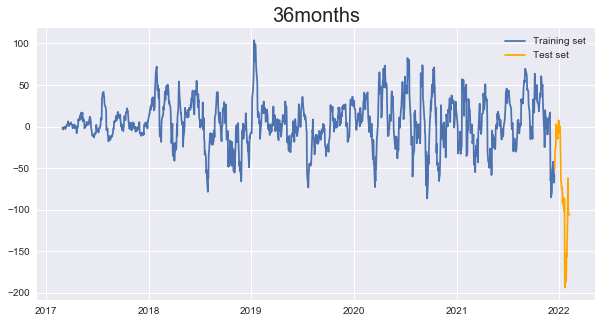

In [40]:
#creating logged test size for 36 months
test_size = 36

#assigning train and test
train_diff = diff[:-test_size]
test_diff = diff[-test_size:]

#creating visualization
plt.title('36months', size=20)
plt.plot(train_diff, label='Training set')
plt.plot(test_diff, label='Test set', color='orange')
plt.legend();

#creating model with logged 36 mo
arima_model_3 = auto_arima(train_diff, seasonal=False, 
                          error_action='ignore',trace = True,
                          supress_warnings=True, n_fits = 50 )
arima_model_3.summary()

Text(0.5, 1.0, 'Forecast')

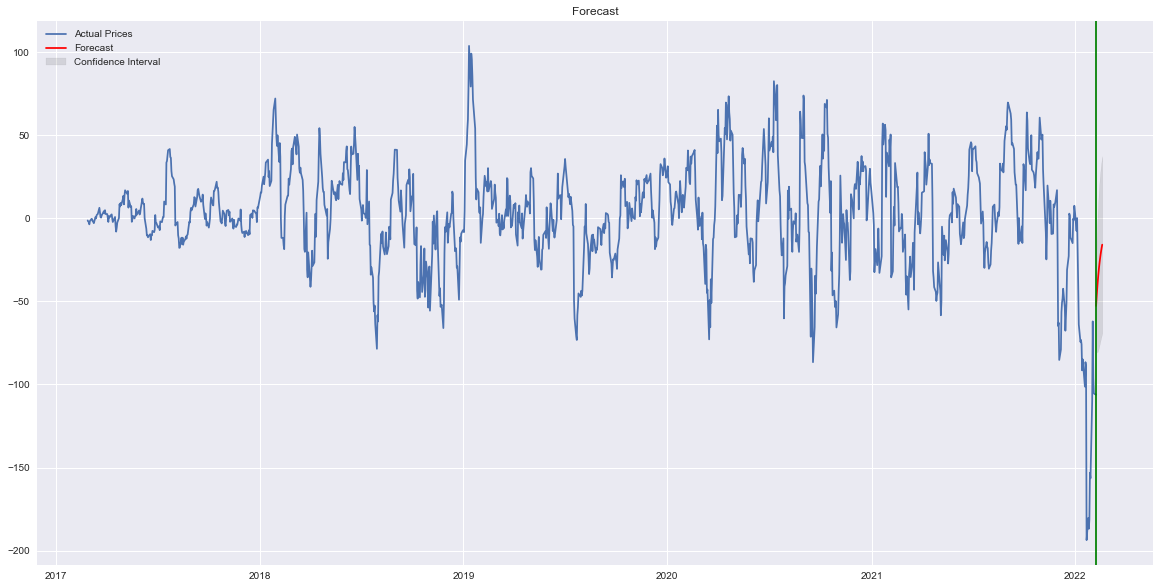

In [41]:
#this model is specifically for zip98498
model_1 = arima_model_3
#including last date from known dates to get pred
dti = pd.date_range(df_idx.index[-1], periods=12, freq="D") 

# creating Forecast
n_periods = 12
fc, confint = model_1.predict(n_periods=12, return_conf_int=True)
index_of_fc = dti

# make series for plotting 
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.plot(diff, label="Actual Prices")
plt.plot(fc_series, color='red', label="Forecast")
#filling in between series
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.10, label="Confidence Interval")
# show where forecast starts
plt.axvline(dti[0], color='green') 
plt.legend()
plt.title("Forecast")

## 8. Result
Reducing the date range definately reduced mean absolute error and mean squared errors. Therefore, in order to get more accurate forecasting, it is important to. According to the logistic regression cross validatoin, the model is 96% accurate. 

## 9. Recommandations
Currently, Stock closing price is decreasing rapidly. 
Prediction says that the closing price will be increased in 24 months period. 
If already bought the stock prior to the recent drop, wait for it to bounce back.
If you have not bought the stock but interested in buying Netflix stocks, I would recommend to buy when it is low.


## 10. Next Steps
Update daily since Stock Market information updates everyday.
Start analysis based on Months and Days to see if accuracy could increase.
Also do analysis on other columns such as high, low in original dataset to see if it can have any effect on the predictions.
